<img src='https://www.met.no/om-oss/logo/_/image/73f29cde-219f-487b-809c-9cdd61032c78:2efc46ce776f5f5337c4b0156ae0cbaa3b6bf6fe/width-768/Met_RGB_Horisontal.jpg' width=200 align=right>
<img src='https://raw.githubusercontent.com/norkyst/norkyst-logo/refs/heads/main/png/horizontal_35_91_100.png' width=200 align=right>

# _Under construction_
# T-S diagram

This notebook will give instructions of how to make a T-S diagram using Noryst v3 data. Data is accessed hrough the Norwegian Meteorological Institute's THREDDS server. https://thredds.met.no/thredds/catalog.html

A T-S diagram is a scatter plot of temperature and salinity with contour lines of density anomalies.

In [15]:
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gsw
import xroms

In [4]:
path = 'https://thredds.met.no/thredds/dodsC/romshindcast/norkyst_v3/norkyst_v3_zdepth_aggr.ncml'

ds = xr.open_dataset(path)

For convenience, I will choose data from one month using the xarray function `.sel()`.

In [5]:
jan = ds.sel(time=slice('2024-01-01', '2024-01-31'))

In [6]:
jan

<xarray.Dataset>
Dimensions:           (X: 2747, Y: 1148, depth: 25, time: 744)
Coordinates:
  * X                 (X) float64 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * depth             (depth) float64 0.0 1.0 2.0 3.0 ... 2e+03 2.25e+03 2.5e+03
  * time              (time) datetime64[ns] 2024-01-01 ... 2024-01-31T23:00:00
    lat               (Y, X) float64 ...
    lon               (Y, X) float64 ...
Data variables:
    projection_stere  int32 ...
    h                 (Y, X) float32 ...
    sea_mask          (Y, X) float32 ...
    Uwind_eastward    (time, Y, X) float32 ...
    Vwind_northward   (time, Y, X) float32 ...
    ln_AKs            (time, depth, Y, X) float32 ...
    salinity          (time, depth, Y, X) float32 ...
    temperature       (time, depth, Y, X) float32 ...
    u_eastward        (time, depth, Y, X) float32 ...
    v_northward       (time, depth, Y, X) float32 ...
    zeta              (time, Y, X) float32 ...
Attributes: (12/33)
    id:                      85f15afb-576c-4459-b4f6-b524420203af
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

The variables of our dataset does not have latitude and longitude as dimensions, but X and Y. So to find data for a wanted location of latitude and longitude, we need to find the closest point within the domain and get the indices of `lat(Y,X)`and `lon(Y, X)`. There are many different approaches to solve this, but the least time consuming would be to use the Python package `xroms`which is made specifically to handle ROMS files. The function `xroms.argsel2d()` uses Great Circle Distance to calculate distance, and finds the closest lat/lon in your dataset.

In [7]:
# Target location
lon = 4.99 ; lat = 58.97

In [8]:
y_idx, x_idx = xroms.argsel2d(ds.lon, ds.lat, lon, lat)

print(ds.lon[y_idx, x_idx].values)
print()
print(ds.lat[y_idx, x_idx].values)

4.986798525332502

58.967353533633556


Note that `xroms.argsel2d()`returns the indices in the order `y, x` and _not_ `x, y`!

Now we have the indices which allows us to access the coordinates of our wanted location. We use the `y,x` indices to make DataArrays of salinity and temperature.

In [9]:
temp = jan.temperature.isel(X=x_idx, Y=y_idx)
salt = jan.salinity.isel(X=x_idx, Y=y_idx)

To make grids for the plotting we want to find the minimum and maximum values of both temperature and salinity, for all time steps and depths. Note that the new DataArrays `temp`and `salt` has fewer dimensions.

In [10]:
# Retrieving maximum and minimum values of salinity and temperature
# For all dates and all depths
tmin = np.nanmin(temp[:, :].values)
tmax = np.nanmax(temp[:, :].values)
smin = np.nanmin(salt[:, :].values)
smax = np.nanmax(salt[:, :].values)

Preparing the plotting using the minimum and maximum values.

In [11]:
# Finding suitable limits for the x and y axis
ydim = int(round(((tmax +0.25) - (tmin-0.25))+1, 0))
xdim = int(round(( (smax +0.25) - (smin-0.25))/0.1+1, 0))

# Making grids for temp and salt
ti = np.linspace(0, ydim - 1, ydim) + tmin - 0.25
si = np.linspace(1, xdim - 1, xdim) * 0.1 + smin - 0.25

Now we can calculate the density using the function `xroms.roms_seawater.density()`.

In [12]:
# Calculate density of waters using xroms
density = np.zeros((ydim, xdim))  # empty array to store density values

for j in range(0, int(ydim)):
    for i in range(0, int(xdim)):
        density[j, i] = xroms.roms_seawater.density(ti[j], si[i], 0)

density = density - 1000  # density is used as an anomaly

Text(0.5, 1.0, 'T-S diagram Januray 2024, 58.97 N, 4.99 E')

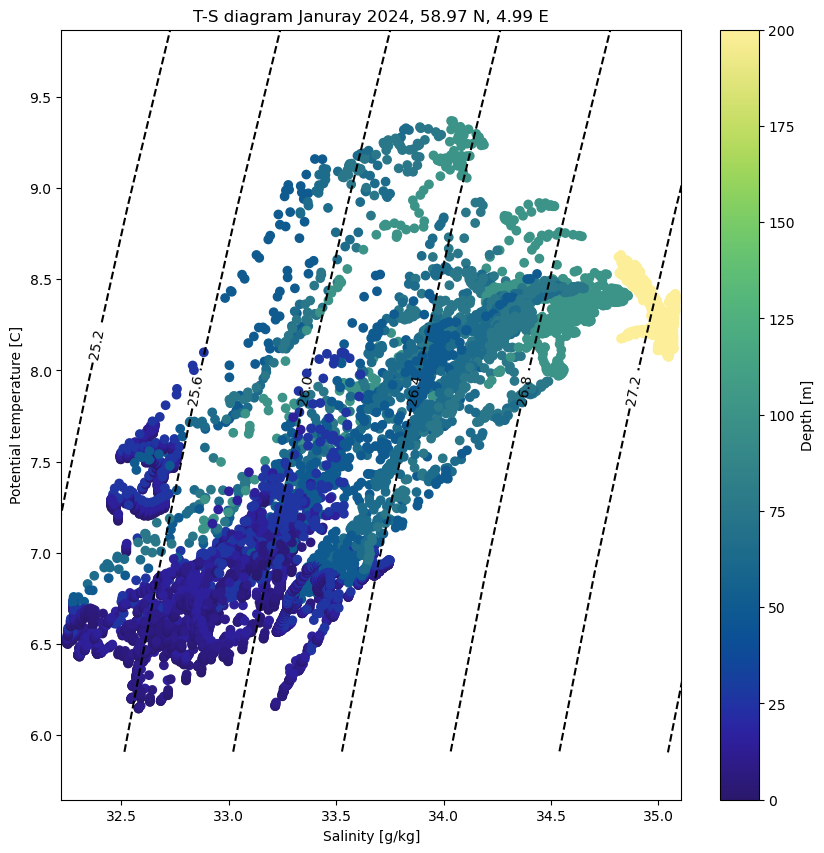

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# List to store scatter plot objects
scatters = []

# Iterate through all dates, make scatter plot for each date
for i in range(len(temp.time)):
     sc = ax.scatter(salt.values[i, :],
                    temp.values[i, :], 
                    c = ds.depth.values, 
                    cmap = cmocean.cm.haline)
     scatters.append(sc)

# Using the last scatter plot object to make a colorbar
plt.colorbar(scatters[-1], ax = ax, label = 'Depth [m]')

# Contour lines for density
cs = ax.contour(si, ti, density, linestyles='dashed', colors='black')
ax.clabel(cs, inline=1, fontsize=10)

# Set limits of axes
ax.set_xlim([smin - 0.025 , smax + 0.025 ])
ax.set_ylim([tmin -0.5, tmax + 0.5])

# Making it pretty
ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential temperature [C]')
ax.set_title(f'T-S diagram Januray 2024, {ds.lat[y_idx, x_idx].values:.2f} N, {ds.lon[y_idx, x_idx].values:.2f} E')